In [2]:
from collections import OrderedDict
import os

import shap
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, accuracy_score
#import shap
#!pip install shap
from sklearn.manifold import TSNE


In [3]:
df = pd.read_csv('votes_all_features.csv')
#df = df[(df.data < '2020-01-01') & (df.data > '2019-01-01')].drop(['covid_auto'],axis=1)
# mask = (df.voto == -1) | (df.voto == 1)
# df = df.loc[mask]
# df.voto = df.voto.replace(-1,0)
df = df.fillna(0)

In [25]:
# df = pd.get_dummies(df,columns=['partido','uf'])#.drop('casa_x_senado',axis=1)
# df.columns

In [4]:
lexicons = [feature for feature in df.columns if feature.startswith('Twitter')]
themes = [feature for feature in df.columns if feature.startswith('theme')]
lex_transcricoes = [feature for feature in df.columns if feature.startswith('transcriptions')]
causal_graph = [feature for feature in df.columns if feature.startswith('influence')]
date = ['year','month']
acoes = [feature for feature in df.columns if feature.startswith('actions')]
at_twitter = [feature for feature in df.columns if feature.startswith('twitter-activity')]
autorias = [feature for feature in df.columns if feature.startswith('authorship')]
disc = [feature for feature in df.columns if feature.startswith('discipline')]
peso = [feature for feature in df.columns if feature.startswith('weight')]
doacoes = [feature for feature in df.columns if feature.startswith('donations')]
frentes = [feature for feature in df.columns if feature.startswith('front')]
inv = [feature for feature in df.columns if feature.startswith('investiment')]
partido = [feature for feature in df.columns if feature.startswith('party')]
features = lexicons + themes + lex_transcricoes + causal_graph + date + acoes + at_twitter + autorias + disc + peso + doacoes + frentes + inv + partido

In [5]:
#[print(col) for col in df.columns[160:405]]
len(frentes)

43

In [6]:
# UNWANTED_COLUMNS = ['id_votacao', 'id_parlamentar', 'id_parlamentar_parlametria','id_proposicao','data','obj_votacao', 'is_nominal','resumo','id','ano','mes','id_votacao', 'id_parlamentar', 'voto', 'id_proposicao', 'data', 'obj_votacao', 'casa_y','casa_x', 'is_nominal','id','resumo','partido']
# lexicons = ['Outrage', 'Vagueness', 'Argumentation', 'Modalization', 'Valuation', 'Sentiment', 'Presupposition', 'Ambiental', 'rt_auto', 'ra_auto', 'rp_auto', 'armas_auto',
#             'racismo_auto', 'impeachment_auto', 'governista', 'oposicao','sentimento','transcricoes_Outrage',
#        'transcricoes_Vagueness', 'transcricoes_Argumentation',
#        'transcricoes_Modalization', 'transcricoes_Valuation',
#        'transcricoes_Sentiment', 'transcricoes_Presupposition',
#        'transcricoes_Ambiental', 'transcricoes_rt_auto',
#        'transcricoes_ra_auto', 'transcricoes_rp_auto',
#        'transcricoes_armas_auto', 'transcricoes_racismo_auto',
#        'transcricoes_covid_auto', 'transcricoes_impeachment_auto',
#        'transcricoes_sentimento']


# features = list(set(df.columns.to_list()) - set(UNWANTED_COLUMNS))

target = ['voto']

In [7]:

DEFAULT_LGB_PARAMS = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 150,
    "verbose": -1,
    "min_data_in_leaf": 5,
    "boost_from_average": True,
    "random_state": 1
}

LABEL_COLUMN_NAME = 'label'
N_FOLDS = 5
N_TIMES_CV = 50

def _robust_evaluation(X, y):
    """N_TIMES_CV times 5-fold cross validation with lgb model
    
    Arguments:
        estimator {[type]} -- [description]
        X {[type]} -- [description]
        y {[type]} -- [description]
    """
    aucs = []
    for seed in range(N_TIMES_CV):
        eval_hist = lgb.cv(DEFAULT_LGB_PARAMS, lgb.Dataset(X, label=y), nfold=N_FOLDS, seed=seed)
        aucs.append(np.mean(eval_hist['auc-mean']))

    score = np.mean(aucs) 

    return score, aucs

def eval_features(df, features, target, random_state):
    """
    5-fold cross validation with LGBMClassifier
    Used to collect results for SHAP analysis
    """
    stats = OrderedDict()
    
    index = df["id_parlamentar"].values.ravel()
    votacoes = df["id_votacao"].values.ravel()
    proposicoes = df["id_proposicao"].values.ravel()
    X = df[features].values
    y = df[target].values.ravel()

    a = [] #array to store AUCs values for each fold
    b = [] #array to store PPVs values for each fold
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)
    max_auc = 0
    iter_max_auc = 0
    for i, (train, val) in enumerate(cv.split(X, y)):
        classifier = lgb.LGBMClassifier(**DEFAULT_LGB_PARAMS)
        classifier = classifier.fit(X[train], y[train])
        
        probas_ = classifier.predict_proba(X[val])
        auc = roc_auc_score(y[val], probas_[:, 1])
        pred_test = classifier.predict(X[val]) #making predictions for test data
        pred_train = classifier.predict(X[train]) #making predictions for train data
        ppv = precision_score(y[val], pred_test) #PPV is also the precision of the positive class
        print(classification_report(y[val],pred_test,output_dict=False))
        a.append(auc)
        b.append(ppv)
        
        if auc > max_auc:
            max_auc = auc
            iter_max_auc = i
        
        
        stats[i] = {}
        stats[i]['model'] = classifier
        stats[i]['auc'] = auc
        stats[i]['X_train'] = X[train]
        stats[i]['y_train'] = y[train]
        stats[i]['y_pred_train'] = pred_train
        stats[i]['X_test'] = X[val]
        stats[i]['y_test'] = y[val]
        stats[i]['y_pred_test'] = pred_test
        stats[i]['index_train'] = index[train]
        stats[i]['index_test'] = index[val]
        stats[i]['votacoes_train'] = votacoes[train]
        stats[i]['votacoes_test'] = votacoes[val]
        stats[i]['proposicoes_train'] = proposicoes[train]
        stats[i]['proposicoes_test'] = proposicoes[val]
        
    stats['mean_auc'] = np.mean(a)
    stats['max_auc'] = np.max(a)
    stats['iter_max_auc'] = iter_max_auc
    stats['mean_ppv'] = np.mean(b)
    return stats, classifier



In [8]:
stats, classifier = eval_features(df,features,target,1)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     47324
           1       0.79      0.81      0.80     54735

    accuracy                           0.78    102059
   macro avg       0.78      0.78      0.78    102059
weighted avg       0.78      0.78      0.78    102059

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
              precision    recall  f1-score   support

           0       0.77      0.76      0.76     47324
           1       0.79      0.81      0.80     54735

    accuracy                           0.78    102059
   macro avg       0.78      0.78      0.78    102059
weighted avg       0.78      0.78      0.78    102059

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_d

In [11]:
stats

OrderedDict([(0,
              {'model': LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
                              metric='auc', min_data_in_leaf=5, num_leaves=150,
                              objective='binary', random_state=1, verbose=-1),
               'auc': 0.8725208220222938,
               'X_train': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
                        0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                        0.        ,  0.        ],
                      [-0.23803359, -0.3531261 , -0.42214335, ...,  0.        ,
                        0.        ,  0.        ],
                      ...,
                      [-0.84206625, -1.03618691, -0.88634381, ...,  0.        ,
                        0.        ,  1.        ],
                      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                        0.        ,  0.        

In [12]:
# collect data
selected_iter = stats['iter_max_auc']
X = stats[selected_iter]['X_train']
y = stats[selected_iter]['y_train']
indexes = stats[selected_iter]['index_train']
votacoes = stats[selected_iter]['votacoes_train']
proposicoes = stats[selected_iter]['proposicoes_train']
y_pred = stats[selected_iter]['y_pred_train']

baseline = accuracy_score(y, np.zeros(len(y)))
acc = accuracy_score(y,y_pred)

# shap explain
model = stats[selected_iter]['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# find misclassfied and correctly classified examples
y_pred = (shap_values[1].sum(1) + explainer.expected_value[1]) > 0
misclassified = y_pred != y
correct_clas = y_pred == y
# find TP, TN, FP and FN examples
tps = [
    True if y_pred[i] == True and y[i] == True else False for i in range(len(y_pred))
]
tns = [
    True if y_pred[i] == False and y[i] == False else False for i in range(len(y_pred))
]
fps = [
    True if y_pred[i] == True and y[i] == False else False for i in range(len(y_pred))
]
fns = [
    True if y_pred[i] == False and y[i] == True else False for i in range(len(y_pred))
]

# feature order
feature_order = list(range(len(features)))
print(f'Mean AUC: {stats["mean_auc"]:.3f}')
print(f'Current fold AUC: {stats[selected_iter]["auc"]:.3f}')
#print(f'Baseline accuracy: {baseline:.3f}')
print(f'Model accuracy: {acc:.3f}')
print('Label distribution on fold:')
print(pd.Series(y).value_counts())
print(f'Number of TPS: {np.array(tps).sum()}')
print(f'Number of TNS: {np.array(tns).sum()}')
print(f'Number of FPS: {np.array(fps).sum()}')
print(f'Number of FNS: {np.array(fns).sum()}')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Mean AUC: 0.873
Current fold AUC: 0.874
Model accuracy: 0.785
Label distribution on fold:
1    218939
0    189294
dtype: int64
Number of TPS: 177068
Number of TNS: 143359
Number of FPS: 45935
Number of FNS: 41871


In [13]:
lex = pd.read_csv("ht_imp_2019-01-01_to_2021-02-22.csv",lineterminator="\n")
ids = lex.id_parlamentar.unique()
names = lex.nome_eleitoral.unique()

id_to_name = dict(zip(ids,names))
name_to_id = dict(zip(names,ids))

In [14]:
name_to_id['LUIS CARLOS HEINZE']

1186

In [16]:
props = pd.read_csv("all_proposition_themes.csv")[["id","ementa"]]
id_e = props.id
ementas = props.ementa
id_to_ementa = dict(zip(id_e,ementas))
ementa_to_id = dict(zip(ementas,id_e))

In [21]:
df[df.id_proposicao == 2201529.0][target].count()

voto    273
dtype: int64

In [22]:
df[df.id_proposicao == 2201529.0]

,id_votacao,id_parlamentar,voto,data,resumo,id_proposicao,theme_Public Administration,"theme_Agriculture, Livestock, Fisheries and Extractivism","theme_Art, Culture and Religion",theme_Cities and Urban Development,...,front_Parliamentary Front in Defense of Water in the Northeast,front_Parliamentary Front in Defense of the Amazon,front_Parliamentary Front in Defense of the Jequitinhonha River,front_Parliamentary Front in Defense of the São Francisco River,front_Parliamentary Front in Favor of Payment for Environmental Services and Sustainable Production,front_Parliamentary Front of Forestry in Brazil,front_Renewable Energies Joint Parliamentary Front - FPE,investiment_total_party_revenue,investiment_total_candidate_revenue,investiment_party_investiment_index
65727,2201529-33,204554,1,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,34500.00,37750.00,0.004558
65728,2201529-33,204521,0,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,18474.57,447044.57,0.003906
65729,2201529-33,204379,1,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,720316.30,807712.30,0.021495
65730,2201529-33,204560,1,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1160000.00,1204707.62,0.014297
65731,2201529-33,204528,0,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,817.80,395075.22,0.001279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,2201529-33,204463,1,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,266.00,134675.50,0.000091
65996,2201529-33,178889,1,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,1.0,0.0,1.0,0.0,885120.00,920076.67,0.007702
65997,2201529-33,204559,1,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,471000.00,982482.27,0.005001
65998,2201529-33,160632,1,2019-06-25,Rejeitado o Requerimento. Sim: 29; não: 244; a...,2201529,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1103699.68,1774659.84,0.045959


In [23]:
inds_lex = [features.index(lex) for lex in lexicons]
inds_themes = [features.index(lex) for lex in themes]
inds_lex_transcricoes = [features.index(lex) for lex in lex_transcricoes]
inds_causal_graph = [features.index(lex) for lex in causal_graph]
#inds_date = [features.index(lex) for lex in date]
inds_acoes = [features.index(lex) for lex in acoes]
inds_at_twitter = [features.index(lex) for lex in at_twitter]
inds_autorias = [features.index(lex) for lex in autorias]
inds_disc = [features.index(lex) for lex in disc]
inds_peso = [features.index(lex) for lex in peso]
inds_doacoes = [features.index(lex) for lex in doacoes]
#inds_lex_sim = [features.index(lex) for lex in lex_sim]
inds_frentes = [features.index(lex) for lex in frentes]
inds_inv = [features.index(lex) for lex in inv]
inds_partido = [features.index(lex) for lex in partido]

grupos = {
    "léxicos twitter":inds_lex,
    "temas":inds_themes,
    "léxicos transcrições":inds_lex_transcricoes,
    "grafo causal": inds_causal_graph,
#    "data": inds_date,
    "ações": inds_acoes,
    "atividade twitter": inds_at_twitter,
    "autorias": inds_autorias,
    "disciplina":inds_disc,
    "peso":inds_peso,
    "doações": inds_doacoes,
 #   "similaridade dos léxicos": inds_lex_sim,
    "frentes":inds_frentes,
    "investimento": inds_inv,
    "partidos": inds_inv
}

all_grupos = ["léxicos twitter","temas","léxicos transcrições","grafo causal","ações","atividade twitter","autorias","disciplina","peso",
              "doações","frentes","investimento","partidos"]
len(all_grupos)

13

In [24]:
def plot_individual(nome,id_proposicao ,shap_values=shap_values, X=X, indexes=indexes,votacoes=votacoes,proposicoes=proposicoes, features=features, tps=tps, tns = tns, fps=fps, fns=fns):
    id_parlamentar = name_to_id[nome]
    print(nome)
    print("summary geral ("+nome+"):")
    shap.summary_plot(
        np.vstack((shap_values[1][indexes == id_parlamentar],shap_values[1][1])),
        np.vstack((X[indexes == id_parlamentar],X[1])),
        feature_names=features)
    
    inds = [features.index(lex) for lex in lexicons]
    
    print("Summary léxicos ("+nome+"):")
    shap.summary_plot(
        shap_values[1][indexes == id_parlamentar][:,inds],
        X[indexes == id_parlamentar][:,inds],
        feature_names=lexicons)
    
    print("Exemplo ambiental ("+nome+"):")
    amb_col = df[features].columns.to_list().index("theme_Environment and Sustainable Development")
    
    vot = votacoes[(X[:,amb_col] == 1)&(proposicoes == id_proposicao)][0]
    votacao_str = str(int(id_proposicao))+": "+id_to_ementa[id_proposicao]
    print(votacao_str)
    #print("Obj. votação:",df[df.id_votacao == vot].obj_votacao.tolist()[0])
        
    shap.decision_plot(
        explainer.expected_value[1],
        shap_values[1][(proposicoes == id_proposicao) & (indexes == id_parlamentar) & (X[:,amb_col] == 1)][0],
        X[(proposicoes== id_proposicao) &(indexes == id_parlamentar) & (X[:,amb_col] == 1)][0],
        link='logit',
        #highlight=fns[0],
        feature_names=features,
        #feature_order='hclust'
        #feature_order=feature_order
    )
    
    valores = []
    for grupo in all_grupos:
        shap_grupo = np.absolute(shap_values[1][(proposicoes == id_proposicao) & (indexes == id_parlamentar) & (X[:,amb_col] == 1)][0][grupos[grupo]]).mean()
        valores.append(shap_grupo)
    
    val_grupos = dict(zip(all_grupos,valores))
    val_grupos = dict(sorted(val_grupos.items(), key=lambda item: item[1]))
    val_groups = list(val_grupos.keys())
    
    shap_individual = shap_values[1][(proposicoes == id_proposicao) & (indexes == id_parlamentar) & (X[:,amb_col] == 1)][0]
    valores = list(tuple(zip(features,shap_individual)))
    valores.sort(key=lambda x:x[1])
    
    print(shap_individual.shape)
    shap_individual = np.expand_dims(shap_individual, axis=0)
    for arr in shap_individual:
        x = explainer.expected_value[1] + np.cumsum(arr)
        accum = 1/(1+np.exp(-x))
        final_proba = accum[-1]
    #print(final_proba)
    prone = "convergente"
    prone2 = "convergente a"
    prone3 = "aumento"
    prone4 = "um alinhamento"
    prone5 = "aumentando"
    prone6 = "negativamente"
    prone7 = "diminuindo"
    biggest = -1
    biggest2 = -2
    lowest = 0
    if final_proba <= 0.5:
        prone = "divergente"
        prone2 = "divergente a"
        prone3 = "diminuição"
        prone4 = "uma divergência"
        prone5 = "diminuindo"
        prone6 = "positivamente"
        prone7 = "aumentando"
        biggest = 0
        biggest2 = 1
        lowest = -1
    
    probas = np.zeros(len(accum))
    for i in range(len(accum)):
        if i != 0:
            probas[i] = accum[i] - accum[i-1]
        else: probas[i] = accum[i] - explainer.expected_value[1]
    
    probs = list(tuple(zip(features,probas)))
    probs.sort(key=lambda x:x[1])
    
    #print(nome,votacao_str,final_proba, prone, nome, prone2 ,valores[biggest][0], prone3, probs[biggest][1], valores[biggest2][0],prone4,nome, prone5, probs[biggest2][1], valores[lowest][0], nome,prone6, probs[lowest][1])
    
    
    template = "Consideramos que, historicamente, os valores e ações do deputado Rodrigo Agostinho no tema Meio Ambiente têm se alinhado aos \
interesses da RAC. Aqui apresentamos a análise do ParlaSCAN para o parlamentar {} na votação {}. Nesse ParlaSCAN temos uma probabilidade de {:.2f}% de alinhamento entre o parlamentar analisado e Rodrigo Agostinho. \
Assim, verificamos que {} tem uma forte tendência a ter um voto {} aos interesses ambientais da RAC. A característica de {} que mais contribuiu \
para uma predição de voto {} Rodrigo Agostinho foi \"{}\", com {} de {:.2f}% na probabilidade. O parâmetro \"{}\" foi o segundo elemento de maior importância para traçarmos {} \
entre {} e Agostinho, {} a probabilidade em {:.2f}%. Para o fator \"{}\", {} teve um comportamento que contribuiu {} para o alinhamento com \
Agostinho, {} a probabilidade de convergência em {:.2f}%.".format(nome,vot,100*(final_proba), nome, prone, nome, prone2 ,valores[biggest][0], prone3, 100*abs(probs[biggest][1]), valores[biggest2][0],prone4,nome, prone5, 100*abs(probs[biggest2][1]), valores[lowest][0], nome,prone6, prone7, 100*abs(probs[lowest][1]))

    
    template2 = "\nO grupo de características {} teve a maior influência na decisão sobre a semelhança entre {} e Agostinho em votações ambientais. \
Em seguida, temos (em ordem de relevância) os grupos {}, {} e {} como elementos da tomada de decisão.".format(val_groups[-1],nome,val_groups[-2],val_groups[-3],val_groups[-4])
    print(template)
    print(template2)
    

ALESSANDRO MOLON
summary geral (ALESSANDRO MOLON):


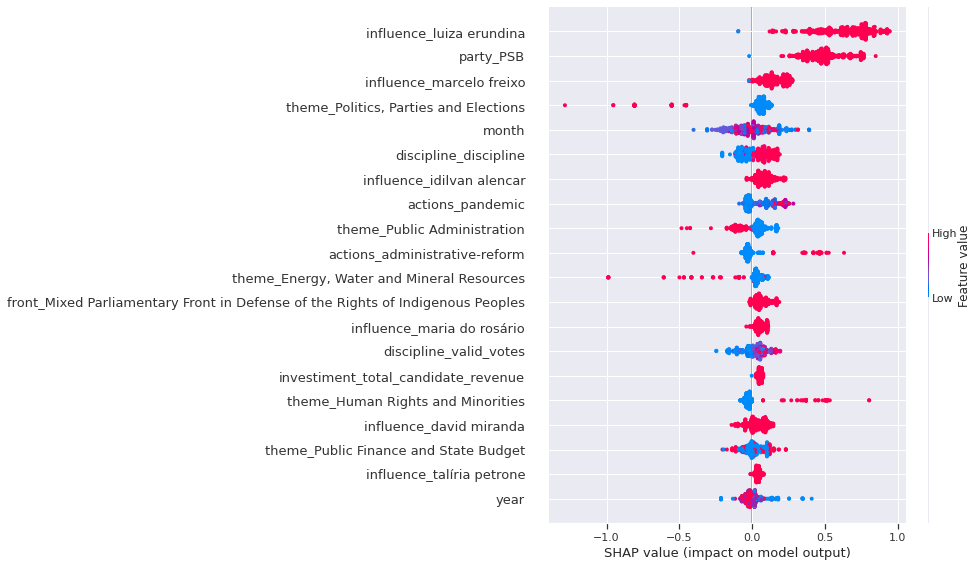

Summary léxicos (ALESSANDRO MOLON):


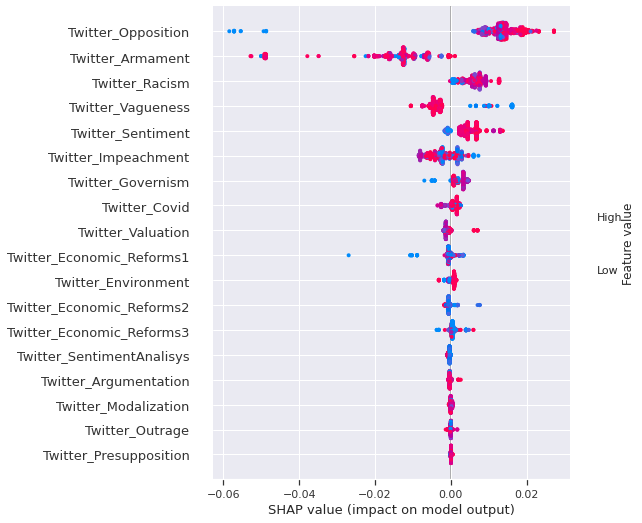

Exemplo ambiental (ALESSANDRO MOLON):
2190237: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre a extensão do prazo para adesão ao Programa de Regularização Ambiental.

NOVA EMENTA: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre o Programa de Regularização Ambiental e o Cadastro Ambiental Rural.


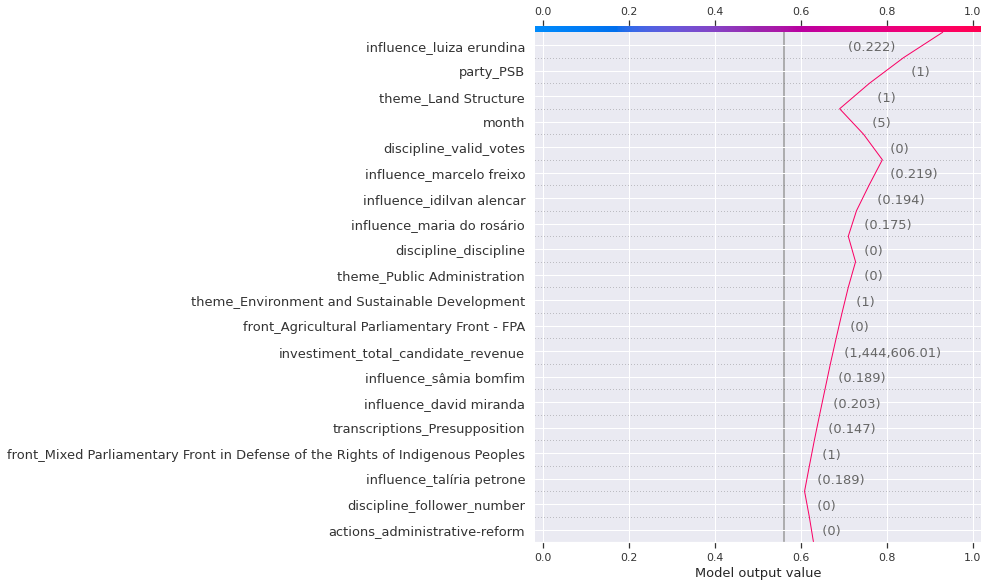

(603,)
Consideramos que, historicamente, os valores e ações do deputado Rodrigo Agostinho no tema Meio Ambiente têm se alinhado aos interesses da RAC. Aqui apresentamos a análise do ParlaSCAN para o parlamentar ALESSANDRO MOLON na votação 2190237-103. Nesse ParlaSCAN temos uma probabilidade de 93.06% de alinhamento entre o parlamentar analisado e Rodrigo Agostinho. Assim, verificamos que ALESSANDRO MOLON tem uma forte tendência a ter um voto convergente aos interesses ambientais da RAC. A característica de ALESSANDRO MOLON que mais contribuiu para uma predição de voto convergente a Rodrigo Agostinho foi "influence_luiza erundina", com aumento de 31.50% na probabilidade. O parâmetro "party_PSB" foi o segundo elemento de maior importância para traçarmos um alinhamento entre ALESSANDRO MOLON e Agostinho, aumentando a probabilidade em 13.84%. Para o fator "month", ALESSANDRO MOLON teve um comportamento que contribuiu negativamente para o alinhamento com Agostinho, diminuindo a probabilidad

In [25]:
plot_individual("ALESSANDRO MOLON",2190237.0)

PAULA BELMONTE
summary geral (PAULA BELMONTE):


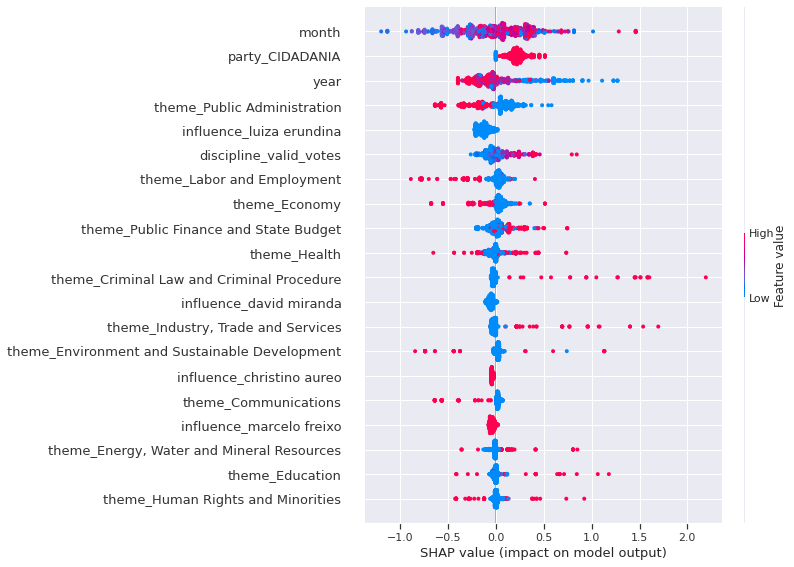

Summary léxicos (PAULA BELMONTE):


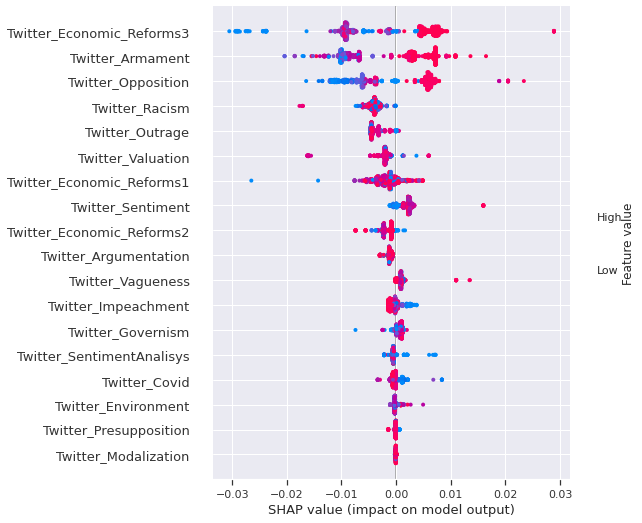

Exemplo ambiental (PAULA BELMONTE):
2190237: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre a extensão do prazo para adesão ao Programa de Regularização Ambiental.

NOVA EMENTA: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre o Programa de Regularização Ambiental e o Cadastro Ambiental Rural.


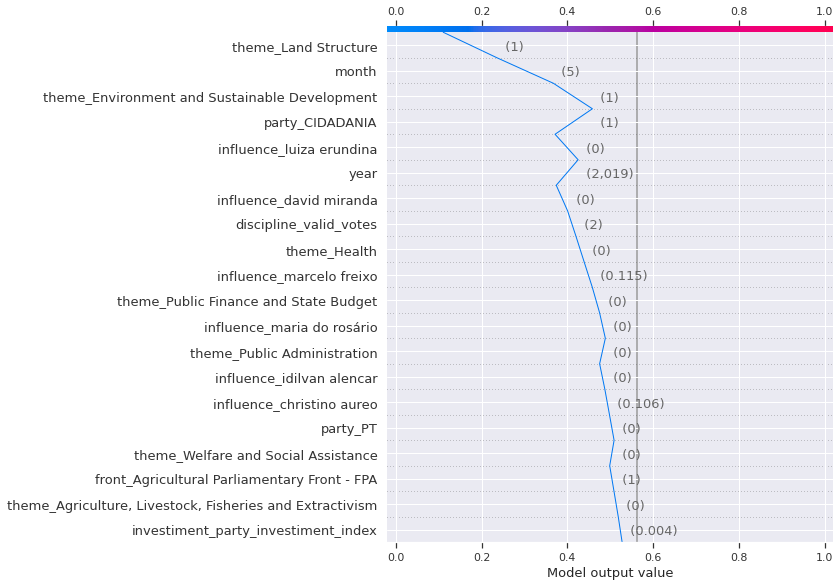

(603,)
Consideramos que, historicamente, os valores e ações do deputado Rodrigo Agostinho no tema Meio Ambiente têm se alinhado aos interesses da RAC. Aqui apresentamos a análise do ParlaSCAN para o parlamentar PAULA BELMONTE na votação 2190237-103. Nesse ParlaSCAN temos uma probabilidade de 11.08% de alinhamento entre o parlamentar analisado e Rodrigo Agostinho. Assim, verificamos que PAULA BELMONTE tem uma forte tendência a ter um voto divergente aos interesses ambientais da RAC. A característica de PAULA BELMONTE que mais contribuiu para uma predição de voto divergente a Rodrigo Agostinho foi "theme_Land Structure", com diminuição de 21.95% na probabilidade. O parâmetro "month" foi o segundo elemento de maior importância para traçarmos uma divergência entre PAULA BELMONTE e Agostinho, diminuindo a probabilidade em 7.37%. Para o fator "party_CIDADANIA", PAULA BELMONTE teve um comportamento que contribuiu positivamente para o alinhamento com Agostinho, aumentando a probabilidade de co

In [26]:
plot_individual("PAULA BELMONTE",2190237)

CAPITÃO ALBERTO NETO
summary geral (CAPITÃO ALBERTO NETO):


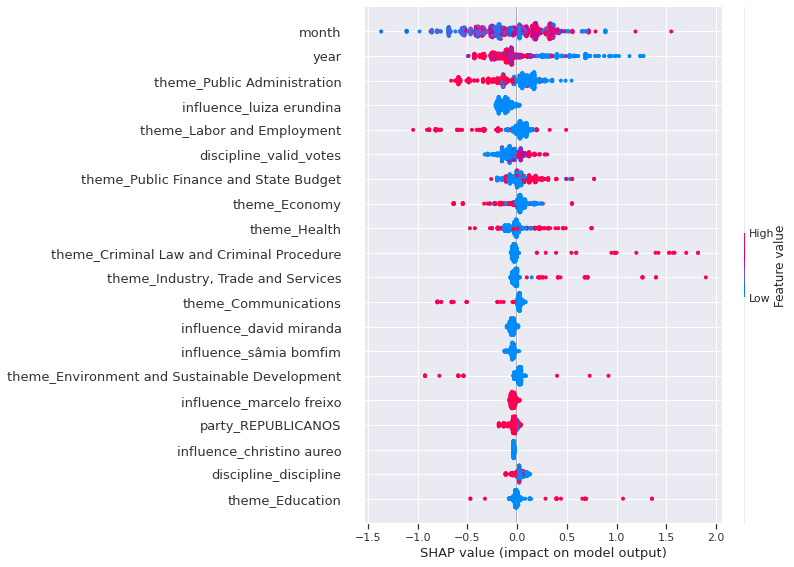

Summary léxicos (CAPITÃO ALBERTO NETO):


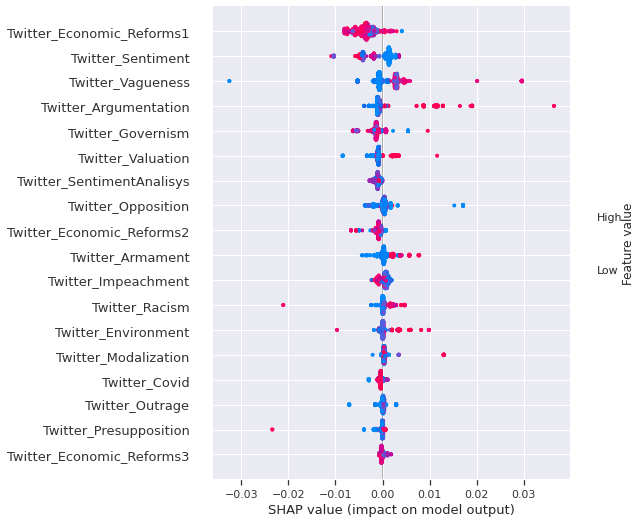

Exemplo ambiental (CAPITÃO ALBERTO NETO):
2190237: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre a extensão do prazo para adesão ao Programa de Regularização Ambiental.

NOVA EMENTA: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre o Programa de Regularização Ambiental e o Cadastro Ambiental Rural.


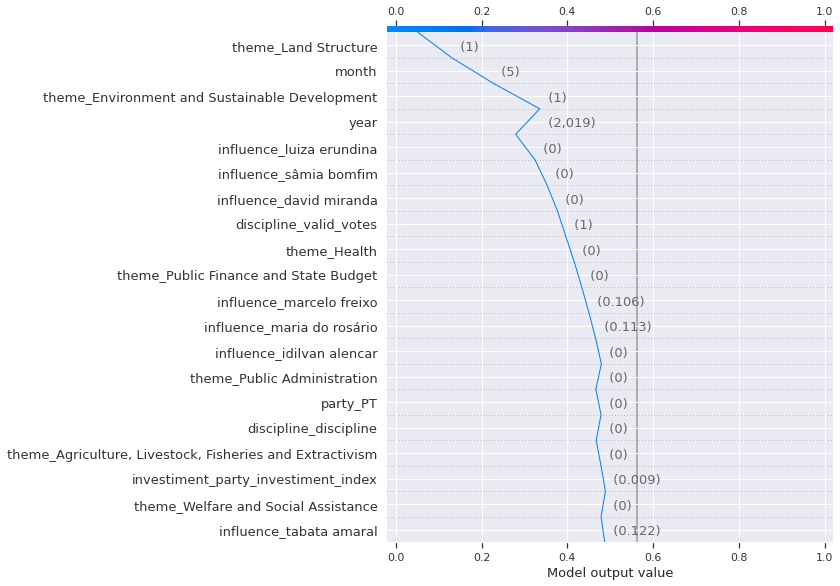

(603,)
Consideramos que, historicamente, os valores e ações do deputado Rodrigo Agostinho no tema Meio Ambiente têm se alinhado aos interesses da RAC. Aqui apresentamos a análise do ParlaSCAN para o parlamentar CAPITÃO ALBERTO NETO na votação 2190237-103. Nesse ParlaSCAN temos uma probabilidade de 5.18% de alinhamento entre o parlamentar analisado e Rodrigo Agostinho. Assim, verificamos que CAPITÃO ALBERTO NETO tem uma forte tendência a ter um voto divergente aos interesses ambientais da RAC. A característica de CAPITÃO ALBERTO NETO que mais contribuiu para uma predição de voto divergente a Rodrigo Agostinho foi "theme_Land Structure", com diminuição de 24.30% na probabilidade. O parâmetro "month" foi o segundo elemento de maior importância para traçarmos uma divergência entre CAPITÃO ALBERTO NETO e Agostinho, diminuindo a probabilidade em 9.69%. Para o fator "year", CAPITÃO ALBERTO NETO teve um comportamento que contribuiu positivamente para o alinhamento com Agostinho, aumentando a p

In [27]:
plot_individual("CAPITÃO ALBERTO NETO",2190237)

In [29]:
def plot_partido(partid ,shap_values=shap_values, X=X, indexes=indexes, features=features, tps=tps, tns = tns, fps=fps, fns=fns):
    partido = df[features].columns.to_list().index("party_"+partid)
    amb_col = df[features].columns.to_list().index("theme_Environment and Sustainable Development")
    print("summary geral ("+partid+"):")
    shap.summary_plot(
        shap_values[1][X[:,partido] == 1],
        X[X[:,partido] == 1],
        feature_names=features)
    
    inds = [features.index(lex) for lex in lexicons]
    
    print("Summary léxicos ("+partid+"):")
    shap.summary_plot(
        shap_values[1][X[:,partido] == 1][:,inds],
        X[X[:,partido] == 1][:,inds],
        feature_names=lexicons)
    
    print("Summary ambiental ("+partid+"):")
    shap.summary_plot(
        shap_values[1][(X[:,partido] == 1) & (X[:,amb_col] == 1)],
        X[(X[:,partido] == 1) & (X[:,amb_col] == 1)],
        feature_names=features)
    
    # print("Exemplo ambiental")
    # shap.decision_plot(
    #     explainer.expected_value[1],
    #     shap_values[1][(tps) & (X[:,partido] == 1) & (X[:,amb_col] == 1)][0],
    #     X[(tps) & (X[:,partido] == 1) & (X[:,amb_col] == 1)][0],
    #     link='logit',
    #     #highlight=fns[0],
    #     feature_names=features,
    #     #feature_order='hclust'
    #     #feature_order=feature_order
    # )

summary geral (PT):


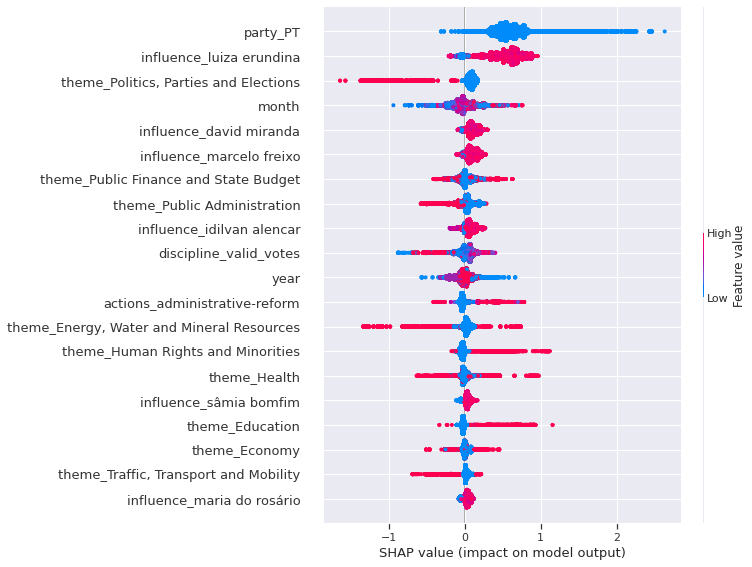

Summary léxicos (PT):


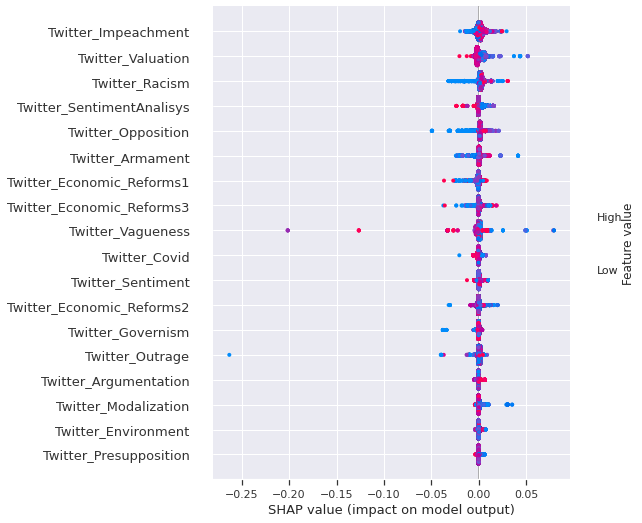

Summary ambiental (PT):


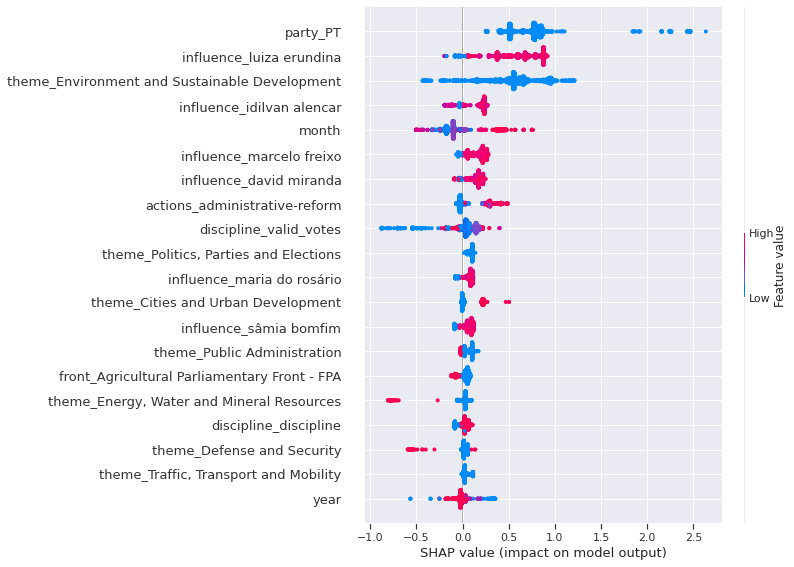

In [30]:
plot_partido("PT")

summary geral (PDT):


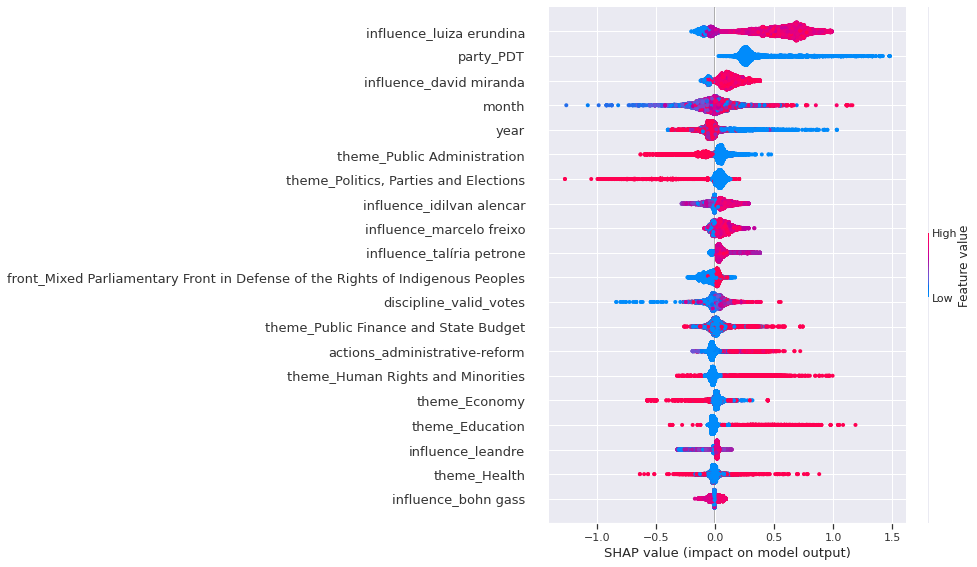

Summary léxicos (PDT):


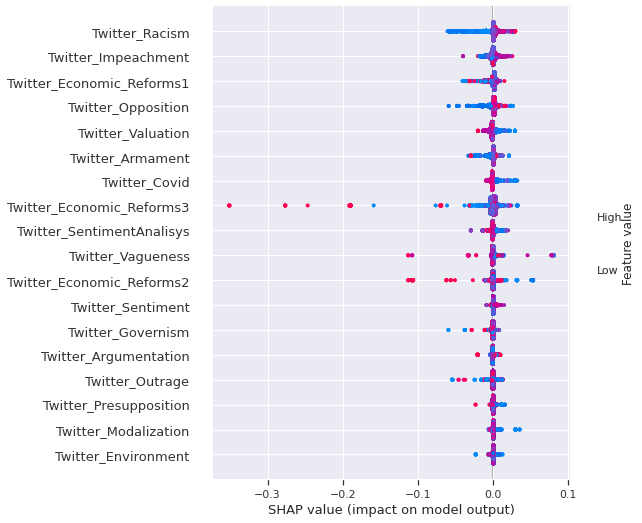

Summary ambiental (PDT):


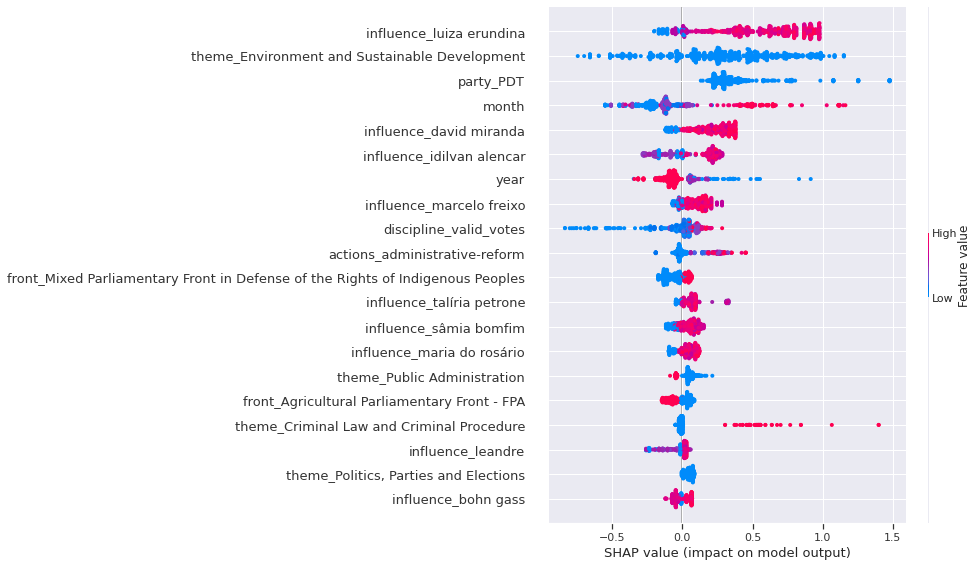

In [31]:
plot_partido("PDT")

summary geral (PP):


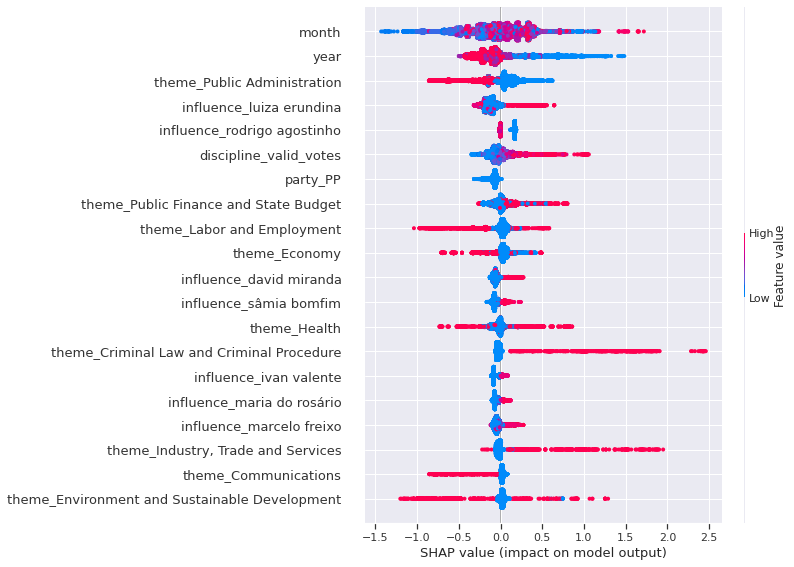

Summary léxicos (PP):


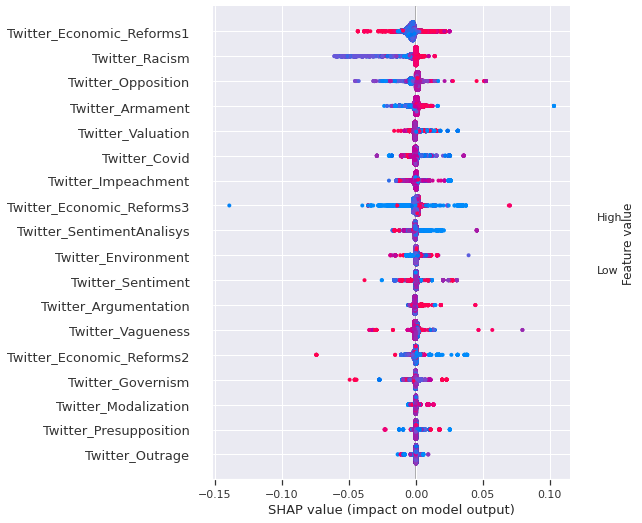

Summary ambiental (PP):


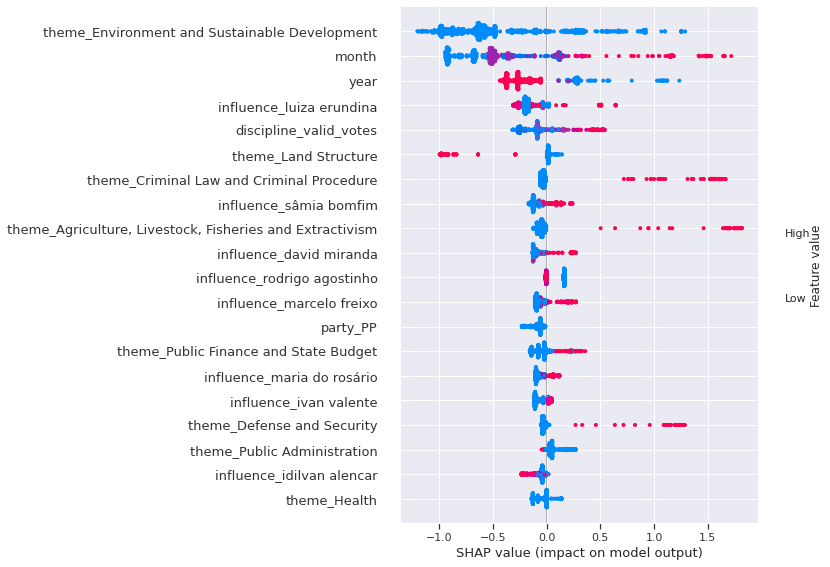

In [32]:
plot_partido("PP")

summary geral (PSL):


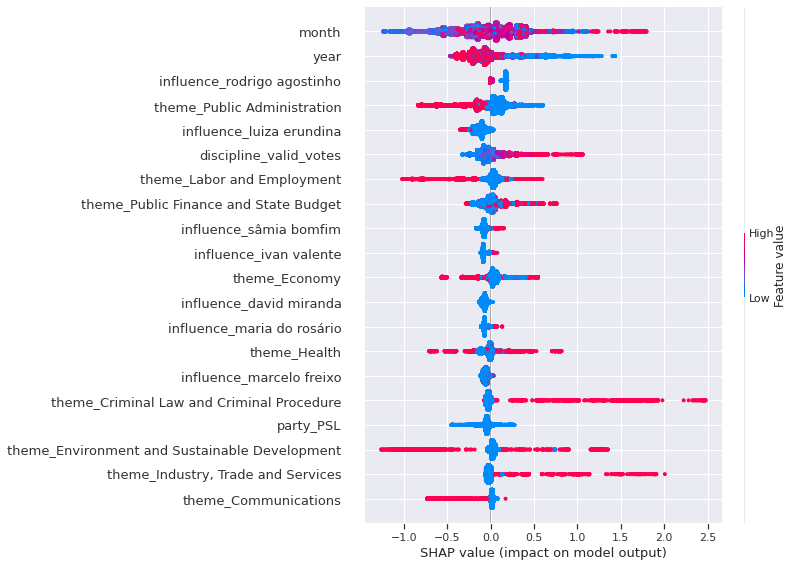

Summary léxicos (PSL):


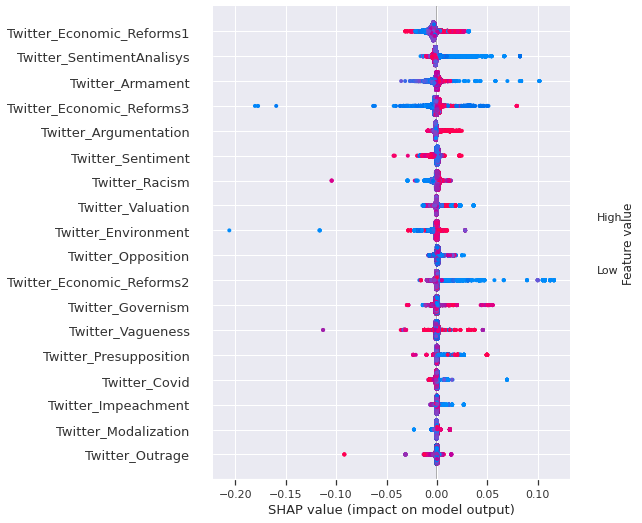

Summary ambiental (PSL):


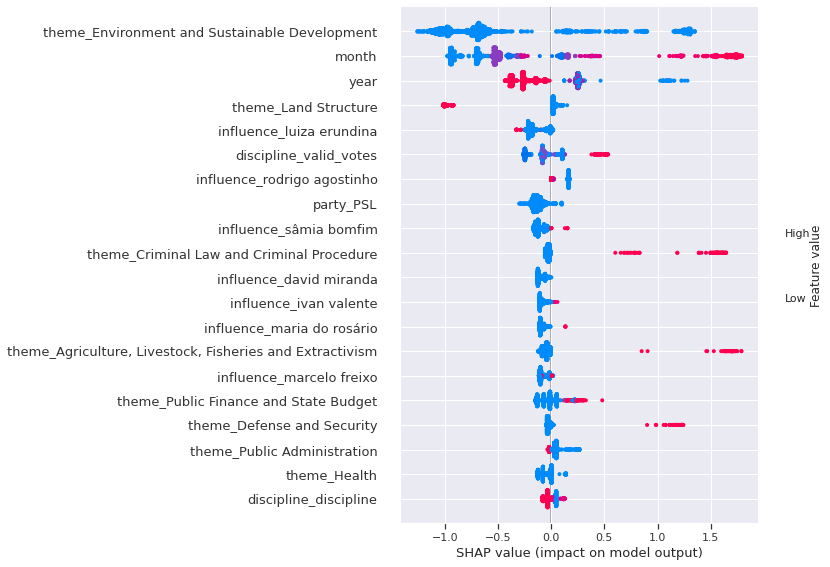

In [33]:
plot_partido("PSL")

## votação ambiental

summary geral (2190237):


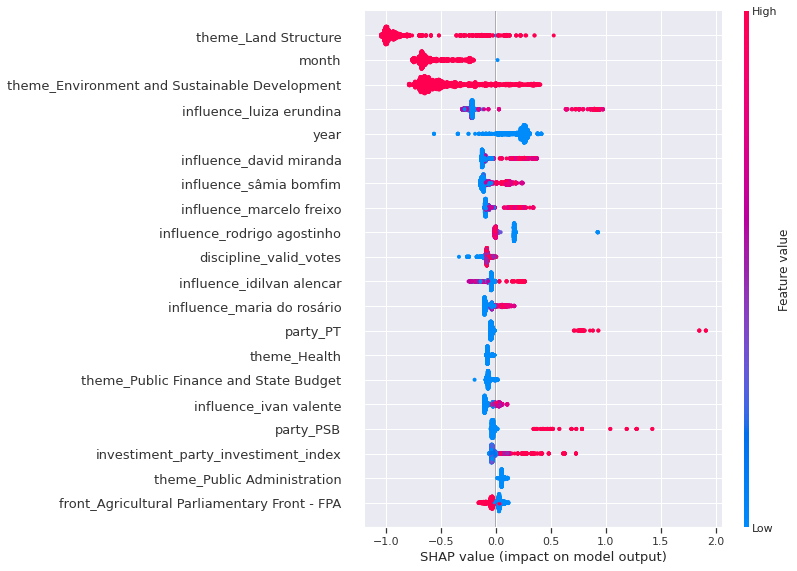

Summary léxicos (2190237):


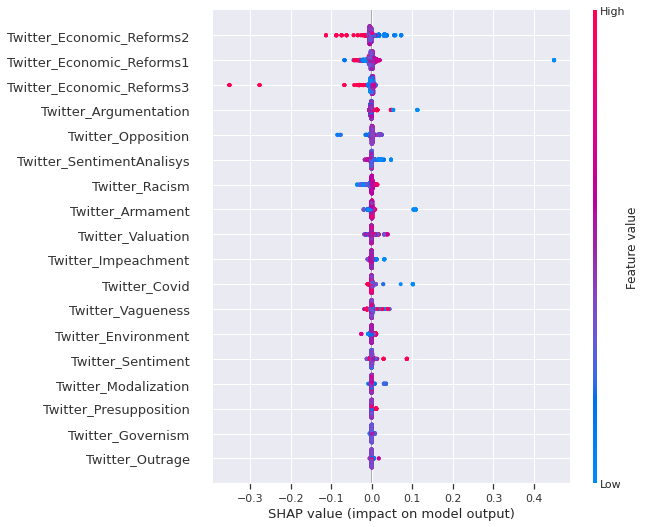

2190237: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre a extensão do prazo para adesão ao Programa de Regularização Ambiental.

NOVA EMENTA: Altera a Lei nº 12.651, de 25 de maio de 2012, para dispor sobre o Programa de Regularização Ambiental e o Cadastro Ambiental Rural.
0
1


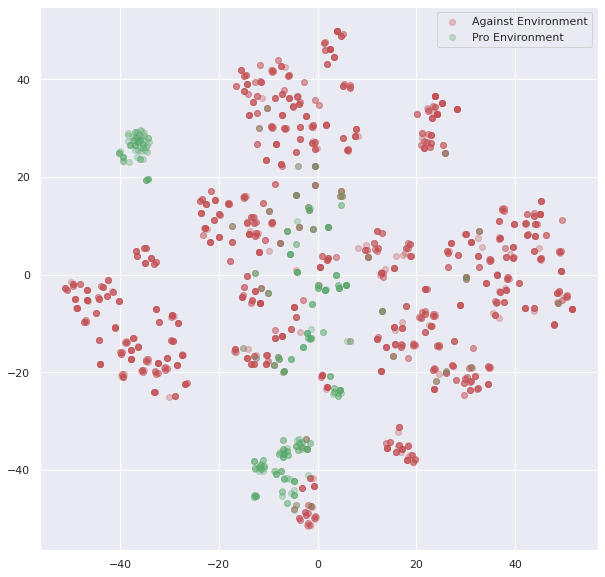

0
1


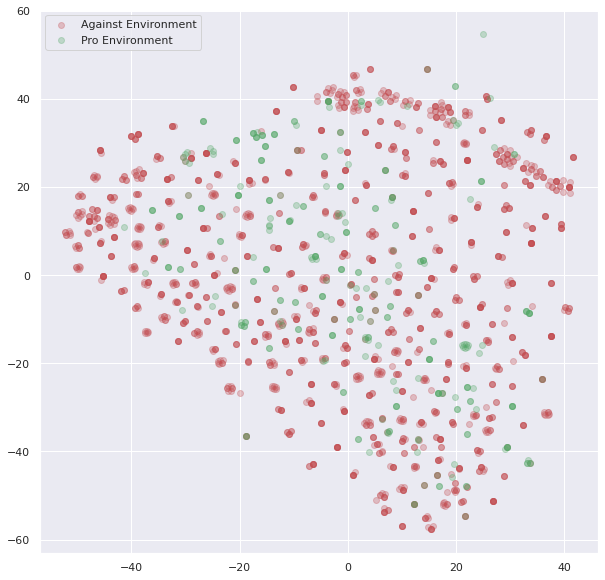

In [ ]:
example_votings = df[df['theme_Environment and Sustainable Development']==1].groupby('id_proposicao').count().index.to_list()

def plot_votacao(id_proposicao ,shap_values=shap_values, X=X,y=y, indexes=indexes,votacoes=votacoes,proposicoes=proposicoes, features=features, tps=tps, tns = tns, fps=fps, fns=fns):
    print("summary geral ("+str(id_proposicao)+"):")
    shap.summary_plot(
        np.vstack((shap_values[1][(proposicoes == id_proposicao)],shap_values[1][0])),
        np.vstack((X[(proposicoes == id_proposicao)],X[0])),
        feature_names=features)
    
    inds = [features.index(lex) for lex in lexicons]
    
    print("Summary léxicos ("+str(id_proposicao)+"):")
    shap.summary_plot(
        shap_values[1][(proposicoes == id_proposicao)][:,inds],
        X[(proposicoes == id_proposicao)][:,inds],
        feature_names=lexicons)
    
    amb_col = df[features].columns.to_list().index("theme_Environment and Sustainable Development")
    
    vot = votacoes[(X[:,amb_col] == 1)&(proposicoes == id_proposicao)][0]
    votacao_str = str(int(id_proposicao))+": "+id_to_ementa[id_proposicao]
    print(votacao_str)
    #print("Obj. votação:",df[df.id_votacao == vot].obj_votacao.tolist()[0])
    
    tsne = TSNE(n_components=2,perplexity=40, random_state=0,learning_rate = 10, n_jobs=-1)
    X_tsne = shap_values[1][(proposicoes == id_proposicao)]
    y_tsne = y[proposicoes == id_proposicao]
    
    X_2d = tsne.fit_transform(X_tsne)
    X_2df = pd.DataFrame(X_2d)
    X_2df.to_csv("tsne_shap_"+str(id_proposicao)+".csv",index=False)
    fig = plt.figure(figsize=(10, 10))
                        
    colors =  'r','g'
    for i, c, label in zip([0,1], colors, ["Against Environment","Pro Environment"]):
        print(i)
        plt.scatter(X_2d[np.squeeze(y_tsne == i), 0], X_2d[np.squeeze(y_tsne == i), 1], c=c, label=label, alpha=0.3)
    plt.legend()
    plt.show()
    
    
    tsne = TSNE(n_components=2,perplexity=40, random_state=0,learning_rate = 10, n_jobs=-1)
    X_tsne = np.nan_to_num(X[(proposicoes == id_proposicao)])
    y_tsne = y[proposicoes == id_proposicao]
    
    X_2d = tsne.fit_transform(X_tsne)
    X_2df = pd.DataFrame(X_2d)
    X_2df.to_csv("tsne_features_"+str(id_proposicao)+".csv",index=False)
    fig = plt.figure(figsize=(10, 10))
                        
    colors =  'r','g'
    for i, c, label in zip([0,1], colors, ["Against Environment","Pro Environment"]):
        print(i)
        plt.scatter(X_2d[np.squeeze(y_tsne == i), 0], X_2d[np.squeeze(y_tsne == i), 1], c=c, label=label, alpha=0.3)
    plt.legend()
    plt.show()

plot_votacao(example_votings[5])

In [35]:
df[features].columns.to_list().index("party_"+"PT")

595